<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Why and What If? Causal Inference For Everyone</h1>
        <h1>Interventions</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import scipy
from scipy.special import expit

import statsmodels.formula.api as smf

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 0b79dce3a06f33ada47b024584d4e38673bc4c41

statsmodels: 0.12.0
scipy      : 1.6.1
matplotlib : 3.3.2
json       : 2.0.9
numpy      : 1.19.2
watermark  : 2.1.0
pandas     : 1.1.3



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

Let us consider this DAG

In [4]:
G = CausalModel()
G.add_causation('B', 'A')
G.add_causation('B', 'Z')
G.add_causation('C', 'Z')
G.add_causation('C', 'D')
G.add_causation('A', 'X')
G.add_causation('X', 'W')
G.add_causation('W', 'Y')
G.add_causation('D', 'Y')
G.add_causation('Z', 'X')
G.add_causation('Z', 'Y')

G.pos = {'B': (-1, 1),              'C': (1, 1),
         'A': (-1, 0), 'Z': (0, 0), 'D': (1, 0),
         'X': (-1, -1), 'W': (0, -1), 'Y': (1, -1),}

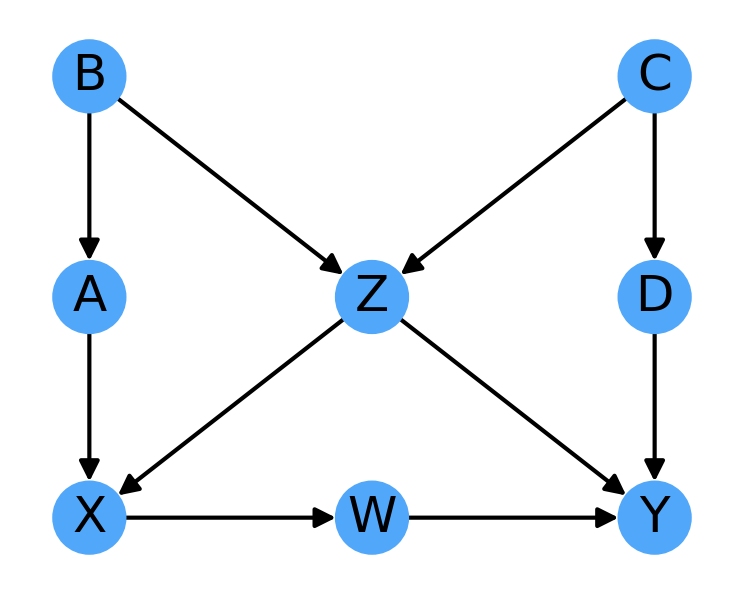

In [5]:
fig, ax = plt.subplots(1, figsize=(3, 2.5))
G.plot(ax=ax)

In [6]:
G.save_model('dags/Primer.Fig.3.8.dot')

## Back-Door Criterion

Back-Door Criterion - A a set of variables Z satisfies the backdoor criterion relative to (X, Y) if:
- no node in Z is a descendant of X, 
- Z blocks every path between X and Y that contains an arrow into X

All backdoor paths go through Z

In [7]:
paths = G.all_paths('X', 'Y')

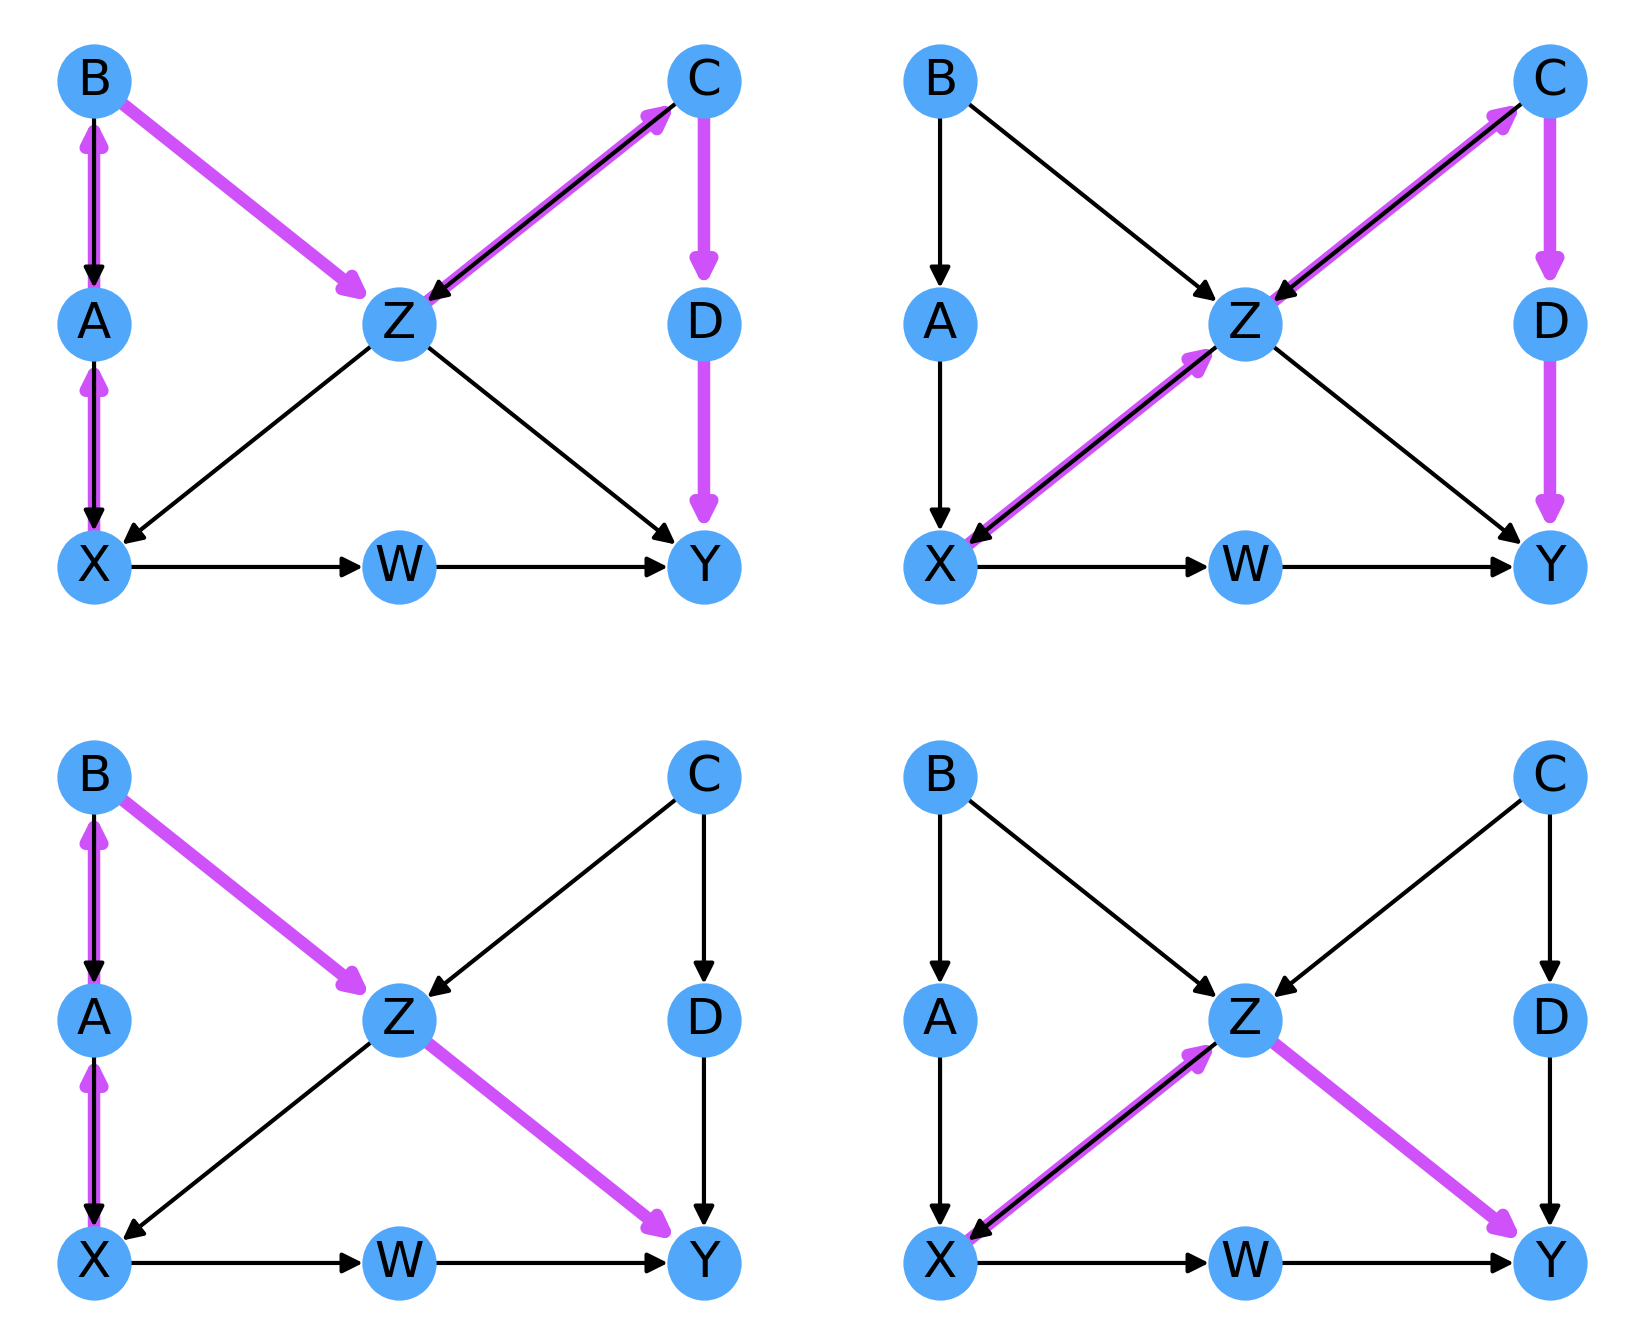

In [8]:
fig, ax_lst = plt.subplots(2, 2, figsize=(6, 5))
ax_lst = np.array(ax_lst).flatten()

pos = 0
for i, path in enumerate(paths):
    if 'W' in path: # skip the direct path
        continue
    G.plot_path(path, ax=ax_lst[pos])
    pos += 1

ax_lst[-1].axis('off');

So we must condition on Z. Since Z is a collider we have to also condition on one of it's input (or their descendants), so one of (A, B, C, or D). Z in addition to any of these 4 nodes will fulfill the back-door criteria. 

The pair ('A', 'Z') being the set of parents of X is an obvious choice.

In [9]:
G.parents('X')

['A', 'Z']

## Front-door Criterion

Front-Door Criterion - A set of variables Z satisfies the front door criterion relative to (X, Y) if:
- Z intercepts all directed paths from X, to Y 
- There is no unblocked path between 
- All back-door paths from Z to Y are blocked by X

The only node that fulfills all three requirements is W

In [10]:
N = 100000
df = pd.DataFrame({
    'B': np.random.normal(0, 1, N), 
    'C': np.random.normal(0, 1, N),})

df['A'] = df['B'] + np.random.normal(0, .1, N)
df['D'] = np.random.binomial(1, expit(df['C']-1))
df['Z'] = np.random.binomial(1, expit(df['B'] + df['C']-2))
df['X'] = np.random.binomial(1, expit(df['Z'] + df['A']))
df['W'] = np.random.binomial(1, expit(-df['X']))
df['Y'] = np.random.binomial(1, expit(-df['D'] - df['W']+ 3*df['Z']))

In [11]:
model_orig = smf.ols('Y~X', df).fit()

In [12]:
model_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2290.
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:59:59   Log-Likelihood:                -71035.
No. Observations:              100000   AIC:                         1.421e+05
Df Residuals:                   99998   BIC:                         1.421e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3750      0.002    164.505      0.000       0.371       0.379
X              0.1494      0.003     47.856      0.000       0.143       0.155
==============================================================================
Omnibus:                   368505.362   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15194.307
Skew:                           0.175   Prob(JB):                         0.00
Kurtosis:                       1.123   Cond. No.                         2.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
X_values = pd.DataFrame({'X': np.array([0, 1])})

In [14]:
model_orig.predict(X_values)

0    0.375019
1    0.524374
dtype: float64

## Intervention

In [15]:
# Replace the values of X with a random number and propagate downstream
df['X'] = np.random.binomial(1, 0.5, N) 

df['W'] = np.random.binomial(1, expit(-df['X']))
df['Y'] = np.random.binomial(1, expit(-df['D'] - df['W']+ 3*df['Z']))

In [16]:
model_int = smf.ols('Y~X', df).fit()

In [17]:
model_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     241.2
Date:                Wed, 26 Jan 2022   Prob (F-statistic):           2.55e-54
Time:                        14:00:00   Log-Likelihood:                -72002.
No. Observations:              100000   AIC:                         1.440e+05
Df Residuals:                   99998   BIC:                         1.440e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4279      0.002    192.686      0.000       0.424       0.432
X              0.0488      0.003     15.529      0.000       0.043       0.055
==============================================================================
Omnibus:                   350704.082   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16513.314
Skew:                           0.191   Prob(JB):                         0.00
Kurtosis:                       1.046   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
model_int.predict(X_values)

0    0.427947
1    0.476773
dtype: float64

## Average Causal Effect

In [19]:
P_int = model_int.predict(X_values)

In [20]:
P_int[1]-P_int[0]

0.0488256279927331

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>